In [1]:
#import libraries/packages
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Problem Statement

As a company, CitiBike, we need to increase our accuracy of predicting the next weeks total rides by Members and Product Type so that we can better forecast our future revenue due to the unpredictable nature of weather impact on our revenue.

We need 3 years of data with the following fields:
<ul>
  <li>Date</li>
  <li>Ride Cat</li>
  <li>Rides</li>
  <li>Weather Car</li>
  <li>Min Temp</li>
  <li>Max Temp</li>
  <li>Freezing Flag</li>
  <li>Heat Flag</li>
  <li>Weekend Flag</li>
  <li>Holiday Flag</li>
</ul>

# IMPORT THE DATA & EDA

In [2]:
#Bring in Data from ML_Data_Model.ipynb 
df = pd.read_csv('final_ml_data.csv')
df['DATE'] =  pd.to_datetime(df['DATE'])
df.head(4)

,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-01,classic_bikecasual,3362,0.76,0.0,57.0,50.0
1,2022-01-01,classic_bikemember,8233,0.76,0.0,57.0,50.0
2,2022-01-01,electric_bikecasual,3227,0.76,0.0,57.0,50.0
3,2022-01-01,electric_bikemember,5941,0.76,0.0,57.0,50.0


In [3]:
# Check null values and datatypes
print(f"MIN DATE: {df['DATE'].min()}")
print(f"MAX DATE: {df['DATE'].max()} \n")
df.info()

MIN DATE: 2022-01-01 00:00:00
MAX DATE: 2023-12-31 00:00:00 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       2920 non-null   datetime64[ns]
 1   RIDE_TYPE  2920 non-null   object        
 2   RIDES      2920 non-null   int64         
 3   PRCP       2920 non-null   float64       
 4   SNOW       2920 non-null   float64       
 5   TMAX       2920 non-null   float64       
 6   TMIN       2920 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 159.8+ KB


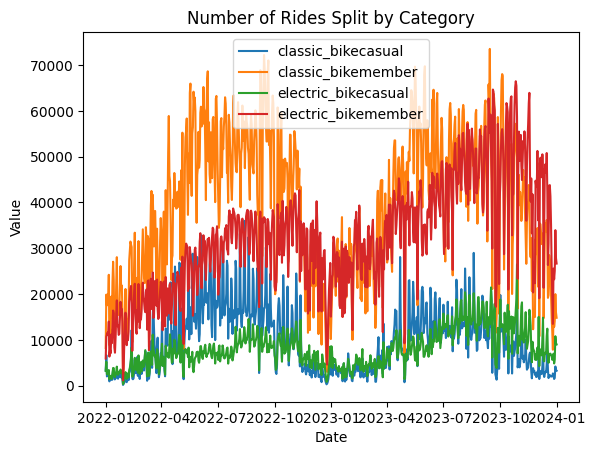

In [223]:
# Plot each different category type daily
fig, ax = plt.subplots()

# Iterate through each category and plot the lines
for category in df['RIDE_TYPE'].unique():
    df_category = df[df['RIDE_TYPE'] == category]
    ax.plot(df_category['DATE'], df_category['RIDES'], label=category)

# Add title, labels, and legend
ax.set_title('Number of Rides Split by Category')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

In [224]:
# Aggregate to Monthly Level 
df_weekly =  df.groupby([pd.Grouper(key='DATE', freq='W-MON'), 'RIDE_TYPE']).sum('RIDES')
df_weekly = df_weekly.reset_index()
df_weekly.head(6)

,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-03,classic_bikecasual,12063,0.80,0.0,156.0,113.0
1,2022-01-03,classic_bikemember,45655,0.80,0.0,156.0,113.0
2,2022-01-03,electric_bikecasual,10960,0.80,0.0,156.0,113.0
3,2022-01-03,electric_bikemember,27744,0.80,0.0,156.0,113.0
4,2022-01-10,classic_bikecasual,14190,0.68,9.7,279.0,196.0
5,2022-01-10,classic_bikemember,114410,0.68,9.7,279.0,196.0


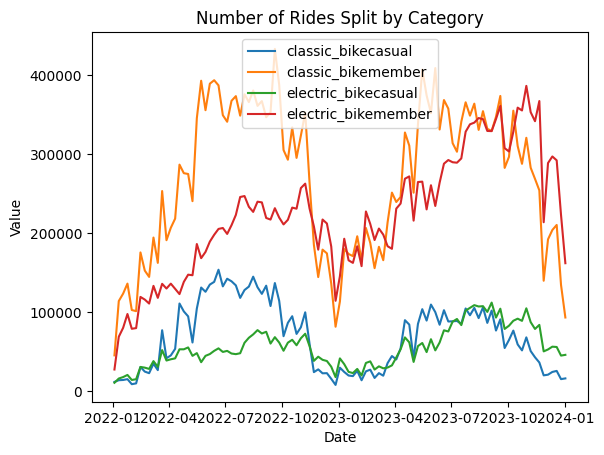

In [225]:
# Plot each different category type monthly
fig, ax = plt.subplots()

# Iterate through each category and plot the lines
for category in df_weekly['RIDE_TYPE'].unique():
    df_category = df_weekly[df_weekly['RIDE_TYPE'] == category]
    ax.plot(df_category['DATE'], df_category['RIDES'], label=category)

# Add title, labels, and legend
ax.set_title('Number of Rides Split by Category')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

In [226]:
# Aggregate to Monthly Level 
df_monthly =  df.groupby([pd.Grouper(key='DATE', freq='M'), 'RIDE_TYPE']).sum()
df_monthly = df_monthly.reset_index()
df_monthly.head(4)

/var/folders/d2/8_sjl_k56djc0380jpk4qxrc0000gn/T/ipykernel_13727/870688647.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly =  df.groupby([pd.Grouper(key='DATE', freq='M'), 'RIDE_TYPE']).sum()


,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-31,classic_bikecasual,65454,3.76,20.4,1192.0,772.0
1,2022-01-31,classic_bikemember,523443,3.76,20.4,1192.0,772.0
2,2022-01-31,electric_bikecasual,80893,3.76,20.4,1192.0,772.0
3,2022-01-31,electric_bikemember,354765,3.76,20.4,1192.0,772.0


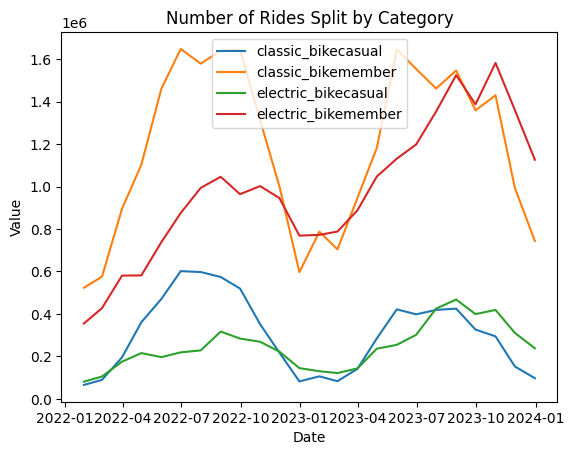

In [227]:
# Plot each different category type monthly
fig, ax = plt.subplots()

# Iterate through each category and plot the lines
for category in df_monthly['RIDE_TYPE'].unique():
    df_category = df_monthly[df_monthly['RIDE_TYPE'] == category]
    ax.plot(df_category['DATE'], df_category['RIDES'], label=category)

# Add title, labels, and legend
ax.set_title('Number of Rides Split by Category')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

## EDA SUMMARY

The data is showing some visual seasonality where Summer Month have an increase or peak amount of rides.

There are no null values.

Member Rides seem to be more popular throughout all the data. Classic bikes are mostly more popular than electric bikes, but in the winter electric bikes seems to overtake Classic bikes in terms of number of rides per day. 

"Ridership" of electric bikes has visually increased on a monthly basis in 2023 compared to 2022. 

**We do not know the following: how much supply has increased, any technology improvements, pricing structure changes, company initiatives, etc. We can't really know what *caused* changes in trends. Since we want to predict 7 days in the future, so it is important to understand what has happenend in the past. Online research could improve exogenous feature inclusions.**

*should do some additional QA checks just to be sure everything is clean*

# MODELING

For modeling I will explore the following and iterate as more information is discovered>

1. **BASELINE** Split by 4 categories and find the best ARMA model optimized using AIC Loss Funciton
2. **SARIMA** If seasonality is identified, we can use SARIMA
3. **INCLUDE WEATHER FEATURES** Include Weather Features to model
4. **INCLUDE DATE FEATURES** Include date features; like holidays, weekends, seasons, etc.
5. **TREE BASED MODELS**

### BASELINE

In [270]:
# SPLIT THE DATA INTO 4 SEGMENTS
df_member_elec = df[df['RIDE_TYPE'] == 'electric_bikemember']
df_memeber_reg = df[df['RIDE_TYPE'] == 'classic_bikemember']
df_casual_elec = df[df['RIDE_TYPE'] == 'electric_bikecasual']
df_casual_reg = df[df['RIDE_TYPE'] == 'classic_bikecasual']
list_dfs = [df_member_elec, df_memeber_reg, df_casual_elec, df_casual_reg] ## ADD dfs TO A LIST

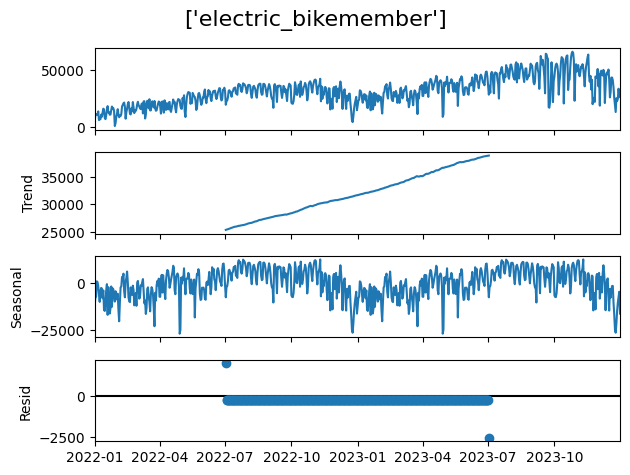

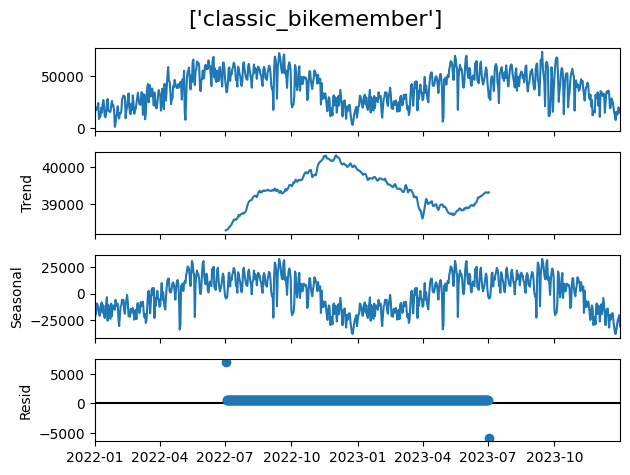

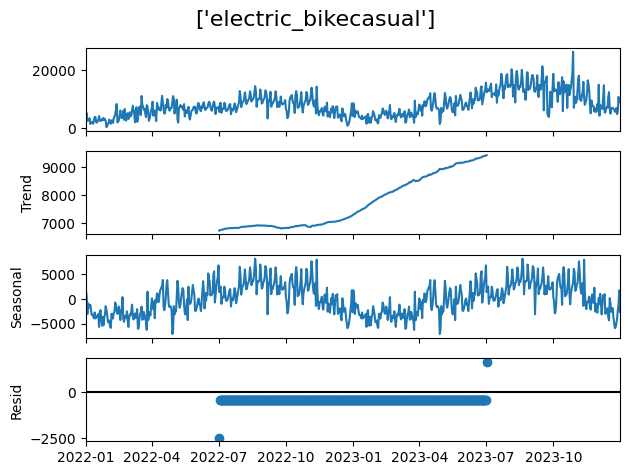

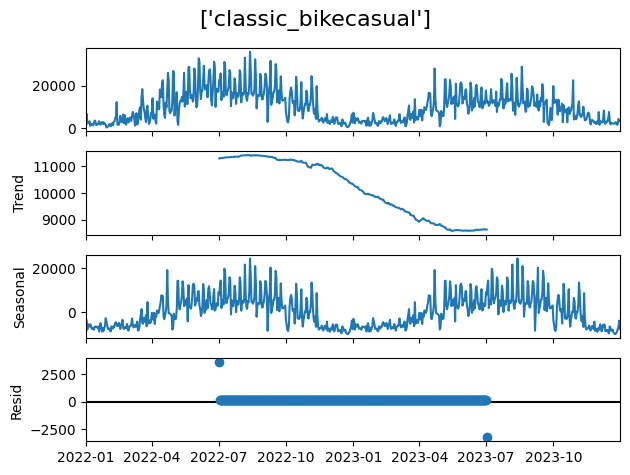

In [271]:
## Show Decomposition for Each Category
for i in list_dfs:
    title = i['RIDE_TYPE'].unique()
    i = i.iloc[:,[0,2]]
    i.set_index('DATE', inplace=True)  
    result = seasonal_decompose(i, period=365)
    fig = result.plot()
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()  # Adjust layout to make room for the title
    plt.subplots_adjust(top=0.9)  # Adjust the top margin to fit the title
    plt.show()

**Appears to be weekly seasonality for each category and definitely not stationary, but we will usd ADF to test.**

In [230]:
# Run ADF test for stationary checks. 
sationary_list = []
for data in list_dfs:
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(data['RIDES'].values)
    if pval < .05:
        sationary_list.append(1)
    else:
        sationary_list.append(0)
    print(data['RIDE_TYPE'].unique())
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)

print(f"There are {sum(sationary_list)} Categories that are statistically considered stationary")

['electric_bikemember']
ADF test statistic: -2.0087416718493762
ADF p-values: 0.282753383401943
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 14304.204090538484
['classic_bikemember']
ADF test statistic: -1.6181081977902876
ADF p-values: 0.47372123581288983
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 14811.24901996233
['electric_bikecasual']
ADF test statistic: -1.8404121362468902
ADF p-values: 0.360590672872207
ADF number of lags used: 20
ADF number of observations: 709
ADF critical values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
ADF best information criterion: 12949.49277792879
['classic_bikecasual']
ADF test statistic: -1.2701494416899382
ADF p-value

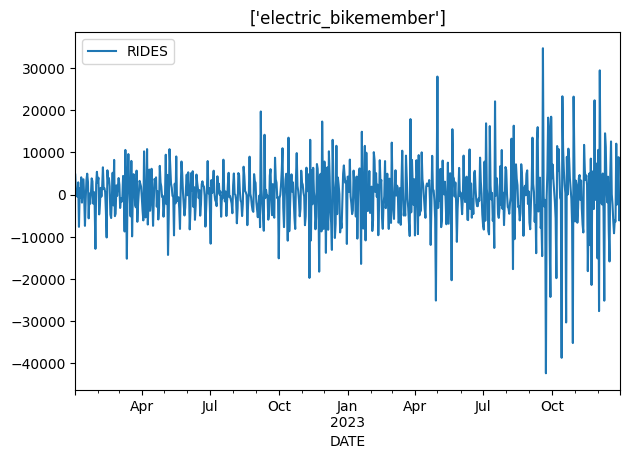

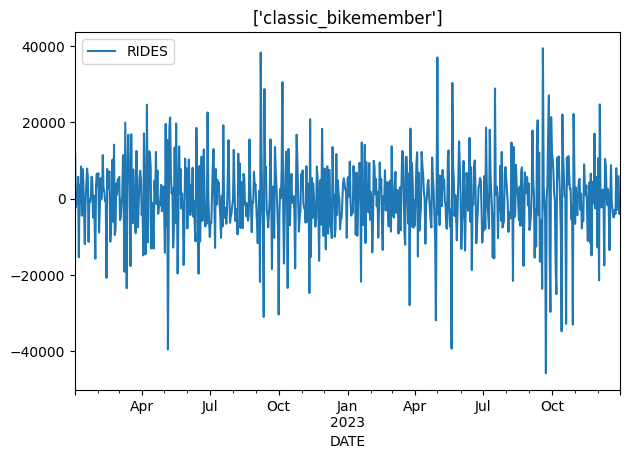

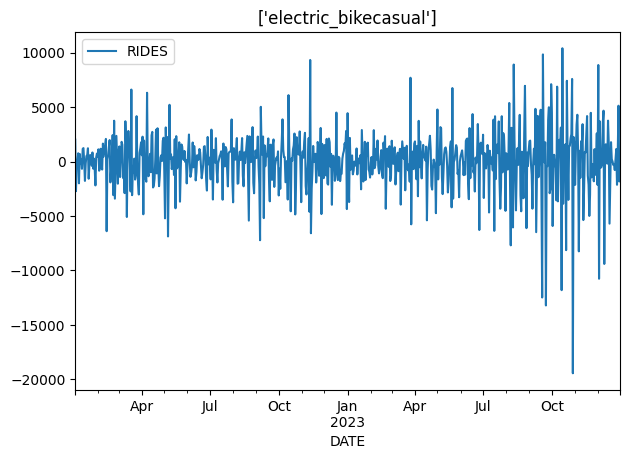

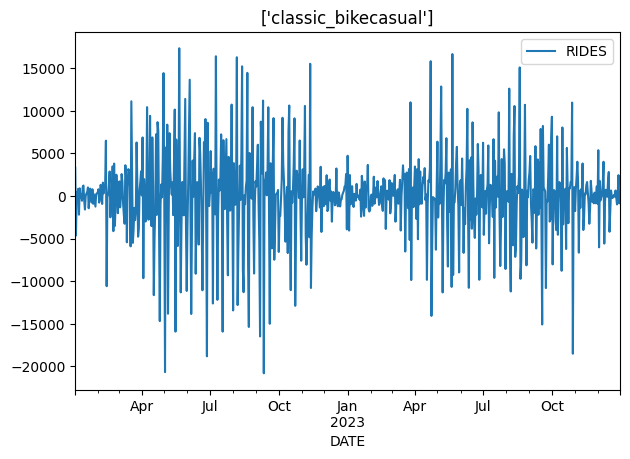

In [231]:
## Show Difference 1 for Each Category
for data in list_dfs:
    title = data['RIDE_TYPE'].unique()
    data = data.iloc[:,[0,2]]
    data.set_index('DATE', inplace=True)  
    diff_values = data.diff().dropna()
    fig = diff_values.plot()
    plt.tight_layout()
    plt.title(title)  # Adjust layout to make room for the title
    plt.subplots_adjust(top=0.9)  # Adjust the top margin to fit the title
    plt.show()

In [232]:
# Run ADF test for stationary checks after differencing. 
sationary_list = []
for data in list_dfs:
    print(data['RIDE_TYPE'].unique())
    data = data['RIDES']
    differenced_series = data.diff().dropna()
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_series)
    if pval < .05:
        sationary_list.append(1)
    else:
        sationary_list.append(0)
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)

print(f"There are {sum(sationary_list)} Categories that are statistically considered stationary")

['electric_bikemember']
ADF test statistic: -8.843097806607057
ADF p-values: 1.6481070756792267e-14
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 14284.468167976958
['classic_bikemember']
ADF test statistic: -9.077747460706801
ADF p-values: 4.1349769705723554e-15
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 14791.856260746143
['electric_bikecasual']
ADF test statistic: -8.051824458682749
ADF p-values: 1.7338078919956394e-12
ADF number of lags used: 20
ADF number of observations: 708
ADF critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
ADF best information criterion: 12932.215337776499
['classic_bikecasual']
ADF test statistic: -8.5998293977113

#### With Differencing by 1, we acheive stationariy ADF p-val <.05 and ADF test stat below critical values

#### Thus, we will proceed with out baseline model as an ARIMA with 1 difference for parameter d

['electric_bikemember']


<Figure size 1600x300 with 0 Axes>

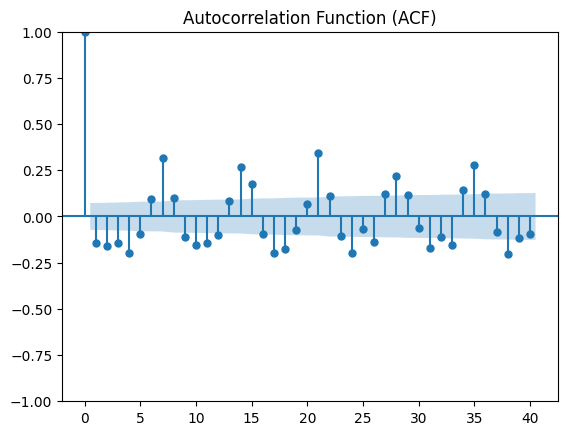

<Figure size 1600x300 with 0 Axes>

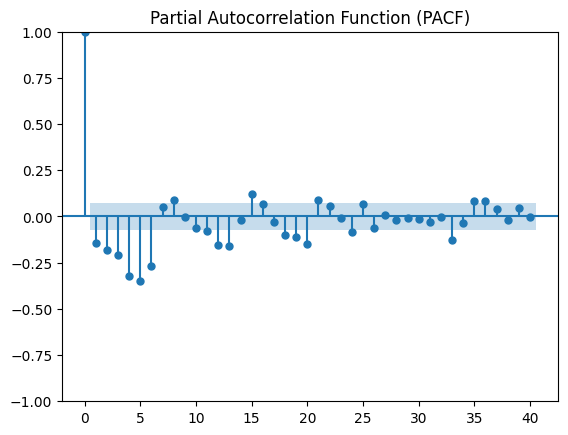

['classic_bikemember']


<Figure size 1600x300 with 0 Axes>

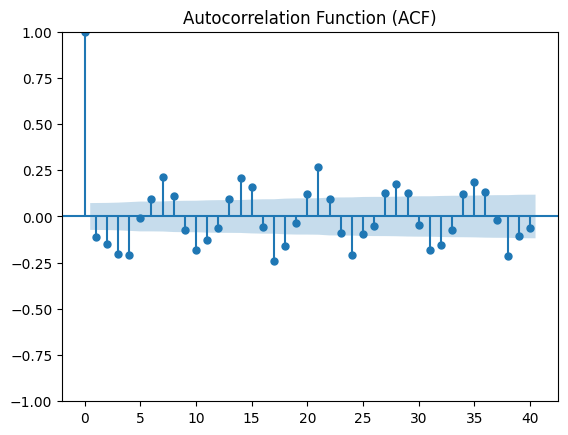

<Figure size 1600x300 with 0 Axes>

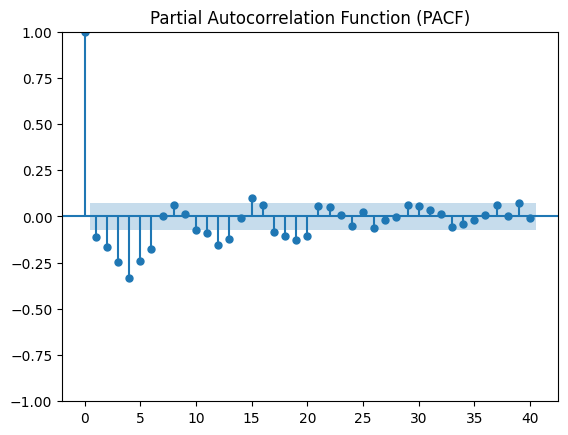

['electric_bikecasual']


<Figure size 1600x300 with 0 Axes>

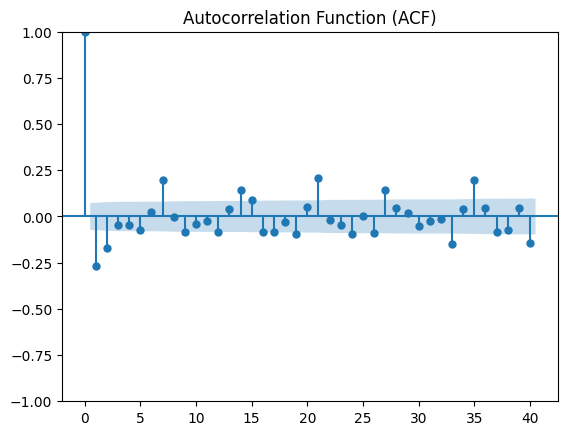

<Figure size 1600x300 with 0 Axes>

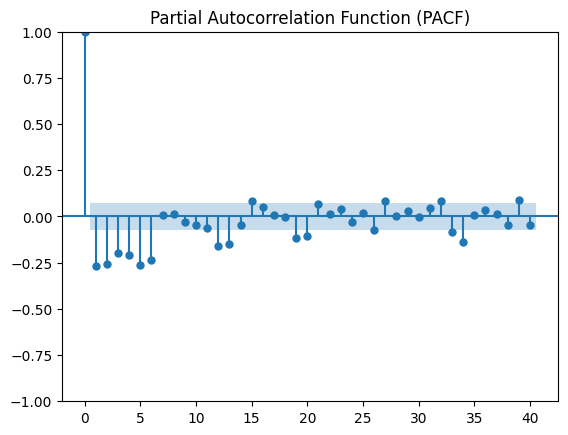

['classic_bikecasual']


<Figure size 1600x300 with 0 Axes>

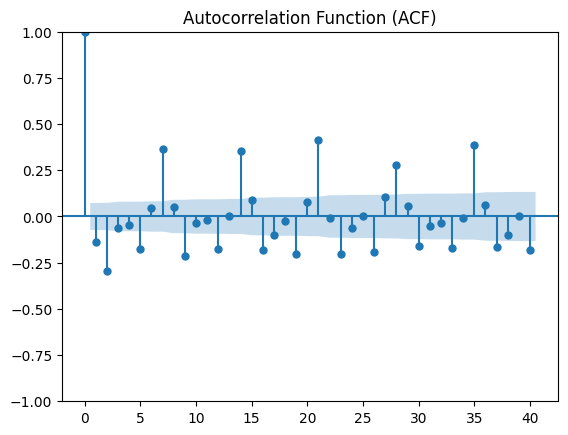

<Figure size 1600x300 with 0 Axes>

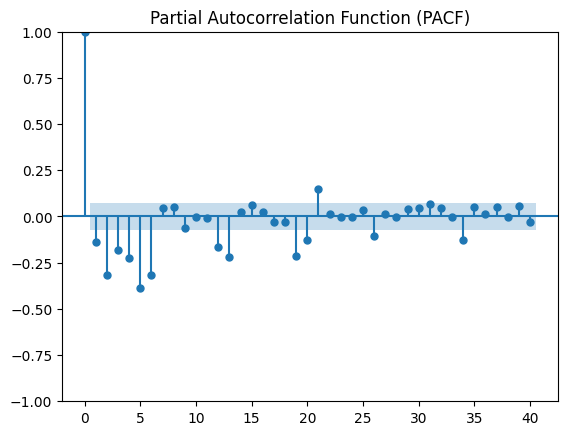

In [233]:
## Plot ACF and PACF
for data in list_dfs:
    title = data['RIDE_TYPE'].unique()
    data = data.iloc[:,[0,2]]
    data.set_index('DATE', inplace=True)  
    diff_values = data.diff().dropna()
    print(title)

    # Plot ACF
    plt.figure(figsize=(16, 3))
    plot_acf(diff_values, lags=40, alpha=0.05)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(16, 3))
    plot_pacf(diff_values, lags=40, alpha=0.05, method='ywm')  # Use "ywm" for compatibility with differenced data
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()


In [234]:
# Training and test split for 7-day prediction
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

train = data[:-7]
test = data[-7:]
test

,RIDES
DATE,
2023-12-25,13490
2023-12-26,25575
2023-12-27,23227
2023-12-28,25071
2023-12-29,33954
2023-12-30,27829
2023-12-31,26666


In [235]:
model = ARIMA(train, order=(3,1,7))   ## Given ACF and PACF, give an educated guess of params
fitted_model = model.fit()
fitted_model.summary()

/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  RIDES   No. Observations:                  723
Model:                 ARIMA(3, 1, 7)   Log Likelihood               -7261.560
Date:                Thu, 02 Jan 2025   AIC                          14545.119
Time:                        22:06:17   BIC                          14595.522
Sample:                    01-01-2022   HQIC                         14564.575
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2940      0.037      7.874      0.000       0.221       0.367
ar.L2          0.1886      0.046      4.091      0.000       0.098       0.279
ar.L3         -0.9522      0.037    -25.738      0.000      -1.025      -0.880
ma.L1         -0.8897      0.047    -19.037      0.000      -0.981      -0.798
ma.L2         -0.2128      0.079     -2.683      0.007      -0.368      -0.057
ma.L3          1.1614      0.079     14.740      0.000       1.007       1.316
ma.L4         -0.6730      0.064    -10.509      0.000      -0.799      -0.548
ma.L5         -0.1154      0.055     -2.093      0.036      -0.223      -0.007
ma.L6          0.0416      0.065      0.638      0.523      -0.086       0.169
ma.L7         -0.0833      0.047     -1.784      0.074      -0.175       0.008
sigma2      3.688e+07   4.88e-09   7.56e+15      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               946.35
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               5.41   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.41e+31. Standard errors may be unstable.
"""

DATE
2023-12-25    31291.246314
2023-12-26    38663.337387
2023-12-27    44628.009813
2023-12-28    43270.922694
2023-12-29    37864.096950
2023-12-30    30574.166523
2023-12-31    29355.137548
Name: predicted_mean, dtype: float64


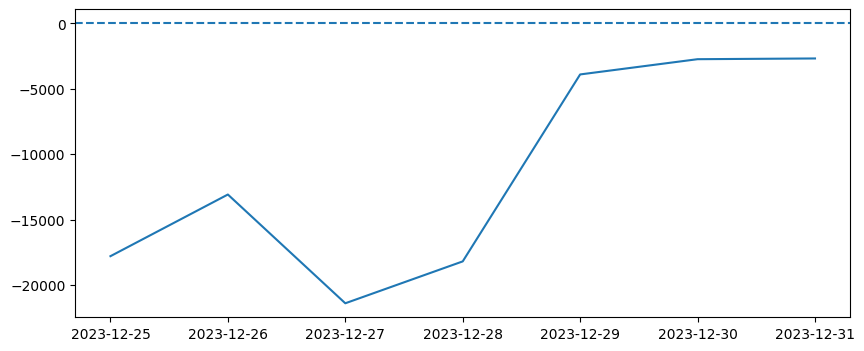

In [236]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test.index)
residuals =  test.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [237]:
print(f"Week total rides (actual): {test.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

Week total rides (actual): 175812
Week total rides (forecast): 255646.91723055203
Mean Absolute Percent Error:  0.5419
Root Mean Squared Error:  13666.881821917252


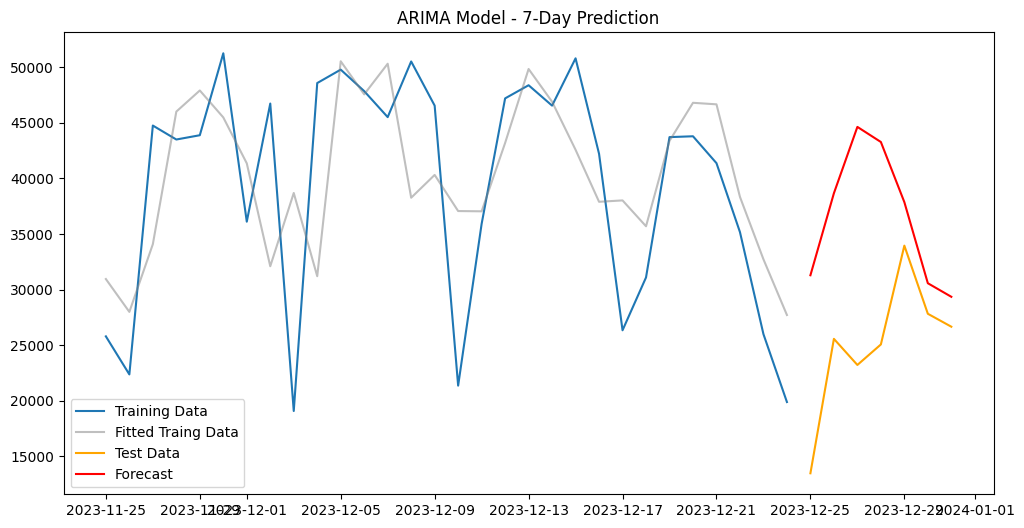

In [238]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

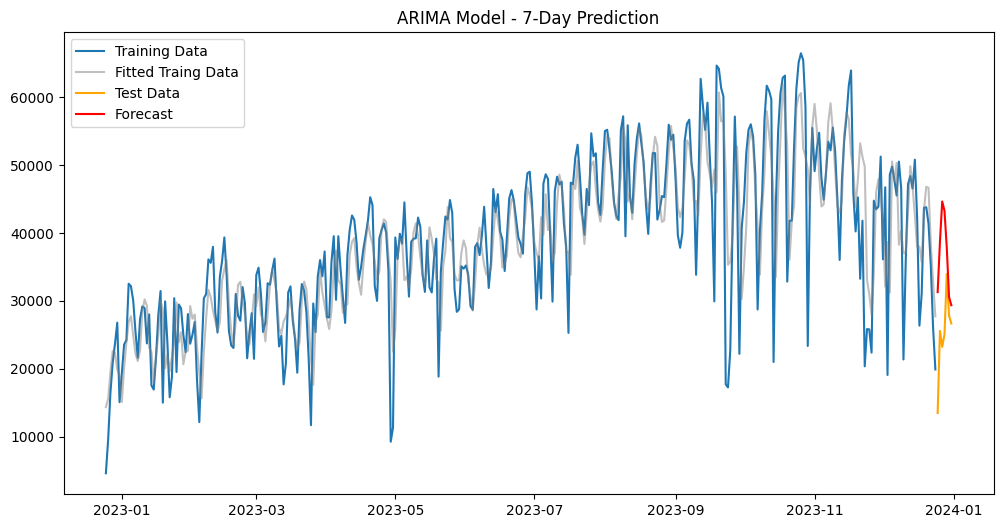

In [239]:
#Plot past year data
plt.figure(figsize=(12, 6))
plt.plot(train[-365:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-365:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

### Use Grid Search to Find Best Parameters based on AIC

In [ ]:
import itertools
# Define parameter ranges
p = range(0, 8)  # Autoregressive terms
d = range(0, 1)  # Differencing terms
q = range(0, 8)  # Moving average terms

# Create all possible combinations
pdq_combinations = list(itertools.product(p, d, q))

In [ ]:
## GRID SEARCH MAPE
# data = list_dfs[0].iloc[:,[0,2]]
# data.set_index('DATE', inplace=True)  

# # Store results
# best_aic = float('inf')  # Initialize with a very high value
# best_params = None       # Placeholder for best parameters
# results = []

# for param in pdq_combinations:
#     try:
#         # Fit ARIMA model
#         model = ARIMA(data, order=param)
#         fitted_model = model.fit()

#         # Forecast the test period
#         forecast = fitted_model.forecast(steps=len(test))
        
#         # Calculate MAPE
#         mape = mean_absolute_percentage_error(test, forecast)
#         results.append((param, mape))

#         # Update best parameters
#         if mape < best_mape:
#             best_mape = mape
#             best_params = param
#     except Exception as e:
#         # Handle cases where model fitting fails
#         continue

In [ ]:
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

# Store results
best_aic = float('inf')  # Initialize with a very high value
best_params = None       # Placeholder for best parameters
results = []

for param in pdq_combinations:
    try:
        # Fit ARIMA model
        model = ARIMA(data, order=param)
        fitted_model = model.fit()
        
        # Record AIC
        aic = fitted_model.aic
        results.append((param, aic))

        # Update best parameters
        if aic < best_aic:
            best_aic = aic
            best_params = param
    except Exception as e:
        # Handle cases where model fitting fails
        continue

In [ ]:
# Sort results by AIC
results.sort(key=lambda x: x[1])
print(f"Best ARIMA parameters: {best_params} with AIC: {best_aic}")
print("Top 5 Results:")
for param, aic in results[:5]:
    print(f"ARIMA{param} - AIC: {aic}")

### Let's see how the model performance changes with these parameters

In [ ]:
model = ARIMA(train, order=(5,1,7))   ## Given ACF and PACF, give an educated guess of params
fitted_model = model.fit()
fitted_model.summary()

In [ ]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test.index)
residuals =  test.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [ ]:
print(f"Week total rides (actual): {test.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

In [ ]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

### The Predictions improved slightly, but it is still not a reasonable model to use given the error size. We also note here that a major US holiday occurs on the test data, so I will try testing on a different week (with no Holiday) to see the difference. If it improves more, we can make a judgement that holidays might be events that affect the model's performance.

In [ ]:
# Training and test split for 7-day prediction
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

train = data[:-27]
test = data[-27:-20]
test

In [ ]:
model = ARIMA(train, order=(5,1,7))   ## Given ACF and PACF, give an educated guess of params
fitted_model = model.fit()
fitted_model.summary()

In [ ]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test.index)
residuals =  test.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [ ]:
print(f"Week total rides (actual): {test.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

In [ ]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

## Baseline Model Conclusion:

#### The model performed much better on a week with no holidays, indicating holiday flag features should be considered. The model still has quite a bit of error 16% MAPE, 7k~ RMSE.

# SARIMA

It appears that there is some seasonality in the model at a weekly level (7 days) we will incorporate this with the SARIMA Model

In [ ]:
# Training and test split for 7-day prediction
data = list_dfs[0].iloc[:,[0,2]]
data.set_index('DATE', inplace=True)  

train = data[:-7]
test = data[-7:]
test

In [ ]:
order = (3,1,0)
seasonal_order = (1,0,1,7)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fitted_model =  model.fit()
fitted_model.summary()

In [ ]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test.index)
residuals =  test.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [ ]:
print(f"Week total rides (actual): {test.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

In [ ]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

### Model Improved slightly with less bias on the holiday test set. The increased performance is not at the optimal level.

## Weather and Holiday Features

Adding exogenous features to the model

In [ ]:
df_clear = df[df['PRCP'] + df['SNOW'] == 0]
df_perc = df[df['PRCP'] + df['SNOW'] > 0]

df_clear.loc[:, 'CAT'] = 'Clear Weather'
df_perc.loc[:, 'CAT'] = 'Rain or Snow'

list_dfs2 = [df_clear, df_perc] ## ADD dfs TO A LIST

In [ ]:
print(f"Avg Rides when percipitation: {df_perc.describe()['RIDES'].mean()}")
print(f"Avg Rides when no percipitation: {df_clear.describe()['RIDES'].mean()}")
print(f"Max Rides when percipitation: {df_perc.describe()['RIDES'].max()}")
print(f"Max Rides when no percipitation: {df_clear.describe()['RIDES'].max()}")

In [ ]:
# Plot each different category type daily
fig, ax = plt.subplots(figsize=(16, 6))

# Iterate through each category and plot the lines
for data in list_dfs2:
    ax.plot(data['DATE'], data['RIDES'], label=data['CAT'].unique(), alpha=.5)

# Add title, labels, and legend
ax.set_title('Number of Rides Split Weather')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

In [ ]:
# Plot each different category type daily
fig, ax = plt.subplots(figsize=(16, 6))

# Iterate through each category and plot the lines
for data in list_dfs2:
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data.iloc[:,[0,2]]
    #data.set_index('DATE', inplace=True)  
    data = data.resample('ME', on='DATE').mean()
    ax.plot(data.index, data['RIDES'], alpha=.5)

# Add title, labels, and legend
ax.set_title('Avg Num of Rides Split Weather')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()

In [ ]:
df['DRY_FLAG'] = (df['PRCP'] + df['SNOW'] == 0).astype(int)
df['MID_TEMP'] = (df['TMAX'] + df['TMIN'])/2

In [ ]:
# SPLIT THE DATA INTO 4 SEGMENTS
df_member_elec = df[df['RIDE_TYPE'] == 'electric_bikemember']
df_memeber_reg = df[df['RIDE_TYPE'] == 'classic_bikemember']
df_casual_elec = df[df['RIDE_TYPE'] == 'electric_bikecasual']
df_casual_reg = df[df['RIDE_TYPE'] == 'classic_bikecasual']
list_dfs = [df_member_elec, df_memeber_reg, df_casual_elec, df_casual_reg] ## ADD dfs TO A LIST

In [ ]:
tst = list_dfs[0]
tst['DATE'] = pd.to_datetime(tst['DATE'])
tst.set_index('DATE', inplace=True)
tst = tst.asfreq('D')

y = tst['RIDES']  # Target variable
X = tst[['PRCP', 'SNOW', 'TMAX', 'TMIN', 'MID_TEMP', 'DRY_FLAG']]

train_y = y[:-7]
train_X = X[:-7]
test_y = y[-7:]
test_X = X[-7:]
train_y

In [ ]:
order = (2,1,0)
seasonal_order = (1,0,1,7)
model = SARIMAX(train_y, exog=train_X, order=order, seasonal_order=seasonal_order)
fitted_model =  model.fit()
fitted_model.summary()

In [ ]:
forecast = fitted_model.forecast(steps=7, exog=test_X)
forecast

In [ ]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7, exog=test_X)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test_y.index)
residuals =  test_y.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [ ]:
print(f"Week total rides (actual): {test.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

In [ ]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train_y[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test_y, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

## Model Performance Increased. Will add holiday information now

In [13]:
df.head()

,DATE,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN
0,2022-01-01,classic_bikecasual,3362,0.76,0.0,57.0,50.0
1,2022-01-01,classic_bikemember,8233,0.76,0.0,57.0,50.0
2,2022-01-01,electric_bikecasual,3227,0.76,0.0,57.0,50.0
3,2022-01-01,electric_bikemember,5941,0.76,0.0,57.0,50.0
4,2022-01-02,classic_bikecasual,6671,0.04,0.0,60.0,39.0


In [5]:
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime

In [31]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-12-30', end='2024-01-02').to_pydatetime()

In [258]:
# SPLIT THE DATA INTO 4 SEGMENTS
df_member_elec = df[df['RIDE_TYPE'] == 'electric_bikemember']
df_memeber_reg = df[df['RIDE_TYPE'] == 'classic_bikemember']
df_casual_elec = df[df['RIDE_TYPE'] == 'electric_bikecasual']
df_casual_reg = df[df['RIDE_TYPE'] == 'classic_bikecasual']
list_dfs = [df_member_elec, df_memeber_reg, df_casual_elec, df_casual_reg] ## ADD dfs TO A LIST

In [268]:
w_h_df = list_dfs[0]
w_h_df['DATE'] = pd.to_datetime(w_h_df['DATE'])
w_h_df.set_index('DATE', inplace=True)
w_h_df = w_h_df.asfreq('D')
w_h_df['HOLIDAY'] = w_h_df.index.isin(holidays).astype(int)
w_h_df['WEEKEND'] = (w_h_df.index.weekday >= 5).astype(int)
w_h_df['DRY_FLAG'] = (w_h_df['PRCP'] + w_h_df['SNOW'] <= .2).astype(int)
w_h_df['MID_TEMP'] = (w_h_df['TMAX'] + w_h_df['TMIN'])/2

/var/folders/d2/8_sjl_k56djc0380jpk4qxrc0000gn/T/ipykernel_13727/3272075792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_h_df['DATE'] = pd.to_datetime(w_h_df['DATE'])


In [269]:
w_h_df[w_h_df.index >= '2023-12-12']

,RIDE_TYPE,RIDES,PRCP,SNOW,TMAX,TMIN,HOLIDAY,WEEKEND,DRY_FLAG,MID_TEMP
DATE,,,,,,,,,,
2023-12-12,electric_bikemember,47191,0.00,0.0,45.0,37.0,0,0,1,41.0
2023-12-13,electric_bikemember,48373,0.00,0.0,47.0,37.0,0,0,1,42.0
2023-12-14,electric_bikemember,46540,0.00,0.0,42.0,34.0,0,0,1,38.0
2023-12-15,electric_bikemember,50792,0.00,0.0,59.0,38.0,0,0,1,48.5
2023-12-16,electric_bikemember,42209,0.00,0.0,53.0,44.0,0,1,1,48.5
2023-12-17,electric_bikemember,26344,0.23,0.0,59.0,46.0,0,1,0,52.5
2023-12-18,electric_bikemember,31095,2.13,0.0,63.0,43.0,0,0,0,53.0
2023-12-19,electric_bikemember,43709,0.00,0.0,44.0,33.0,0,0,1,38.5
2023-12-20,electric_bikemember,43785,0.00,0.0,45.0,32.0,0,0,1,38.5


In [261]:
y = w_h_df['RIDES']  # Target variable
X = w_h_df[['PRCP', 'TMAX', 'TMIN', 'WEEKEND', 'HOLIDAY', 'MID_TEMP', 'DRY_FLAG']]

train_y = y[-90:-7]
train_X = X[-90:-7]
test_y = y[-7:]
test_X = X[-7:]
train_y

DATE
2023-10-03    12819
2023-10-04    13435
2023-10-05    13262
2023-10-06    12640
2023-10-07     9075
              ...  
2023-12-20     6982
2023-12-21     6997
2023-12-22     6684
2023-12-23     6437
2023-12-24     5655
Freq: D, Name: RIDES, Length: 83, dtype: int64

In [262]:
order = (2,1,0)
seasonal_order = (1,0,1,7)
model = SARIMAX(train_y, exog=train_X, order=order, seasonal_order=seasonal_order)
fitted_model =  model.fit()
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07840D+00    |proj g|=  1.13128D-01

At iterate    5    f=  9.07227D+00    |proj g|=  9.06356D-04

At iterate   10    f=  9.07170D+00    |proj g|=  3.00127D-02

At iterate   15    f=  9.07038D+00    |proj g|=  5.26897D-04

At iterate   20    f=  9.07026D+00    |proj g|=  8.21987D-03

At iterate   25    f=  9.06814D+00    |proj g|=  1.45708D-02


 This problem is unconstrained.



At iterate   30    f=  9.06791D+00    |proj g|=  2.73550D-04

At iterate   35    f=  9.06791D+00    |proj g|=  4.42346D-04

At iterate   40    f=  9.06787D+00    |proj g|=  5.79825D-03

At iterate   45    f=  9.06723D+00    |proj g|=  1.34163D-02

At iterate   50    f=  9.06675D+00    |proj g|=  5.86216D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   5.862D-03   9.067D+00
  F =   9.0667484210200939     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/westonshuken/anaconda3/envs/usual/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               RIDES   No. Observations:                   83
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood                -752.540
Date:                             Thu, 02 Jan 2025   AIC                           1529.080
Time:                                     22:17:25   BIC                           1557.961
Sample:                                 10-03-2023   HQIC                          1540.675
                                      - 12-24-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRCP        -463.8873   1166.756     -0.398      0.691   -2750.688    1822.913
TMAX         169.3116    271.895      0.623      0.533    -363.593     702.216
TMIN          32.4589    269.797      0.120      0.904    -496.334     561.252
WEEKEND     2205.8326    604.160      3.651      0.000    1021.700    3389.965
HOLIDAY    -1389.4671   1376.169     -1.010      0.313   -4086.709    1307.775
MID_TEMP     100.8854    516.105      0.195      0.845    -910.662    1112.432
DRY_FLAG    5915.9597   1042.463      5.675      0.000    3872.769    7959.151
ar.L1         -0.3569      0.128     -2.777      0.005      -0.609      -0.105
ar.L2         -0.1909      0.162     -1.175      0.240      -0.509       0.128
ar.S.L7       -0.3944      0.578     -0.682      0.495      -1.528       0.739
ma.S.L7        0.5690      0.536      1.062      0.288      -0.482       1.620
sigma2      5.521e+06   9.94e+05      5.555      0.000    3.57e+06    7.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.55   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.21   Prob(JB):                         0.99
Heteroskedasticity (H):               0.45   Skew:                             0.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+20. Standard errors may be unstable.
"""

In [263]:
forecast = fitted_model.forecast(steps=7, exog=test_X)
forecast


2023-12-25    3583.895110
2023-12-26    5540.380463
2023-12-27    -839.276542
2023-12-28       7.436406
2023-12-29    7325.485474
2023-12-30    6495.987402
2023-12-31    5347.606384
Freq: D, Name: predicted_mean, dtype: float64

DATE
2023-12-25    3583.895110
2023-12-26    5540.380463
2023-12-27    -839.276542
2023-12-28       7.436406
2023-12-29    7325.485474
2023-12-30    6495.987402
2023-12-31    5347.606384
Freq: D, Name: predicted_mean, dtype: float64


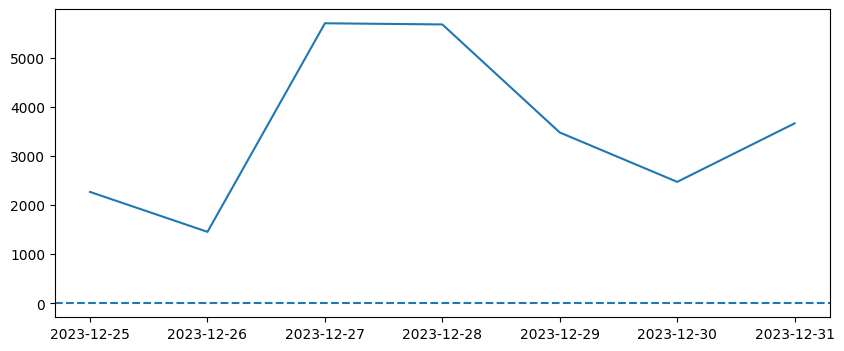

In [264]:
# Forecasting the next 7 days
forecast = fitted_model.forecast(steps=7, exog=test_X)

# Convert to Series for comparison
forecast_series = pd.Series(forecast, index=test_y.index)
residuals =  test_y.squeeze() - forecast_series
print(forecast_series)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')

In [265]:
# print(f"Week total rides (actual): {train_y.squeeze().sum()}")
# print(f"Week total rides (forecast): {fitted_model.fittedvalues.sum()}")
# print('Mean Absolute Percent Error: ', round(np.mean(abs((train_y.squeeze() - fitted_model.fittedvalues)/train_y.squeeze())),4))
# print("Root Mean Squared Error: ", np.sqrt(np.mean((train_y.squeeze() - fitted_model.fittedvalues)**2)))

In [266]:
print(f"Week total rides (actual): {test_y.squeeze().sum()}")
print(f"Week total rides (forecast): {forecast.sum()}")
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_y.squeeze())),4))
print("Root Mean Squared Error: ", np.sqrt(np.mean(residuals**2)))

Week total rides (actual): 52162
Week total rides (forecast): 27461.514695885817
Mean Absolute Percent Error:  0.5386
Root Mean Squared Error:  3845.408697578928


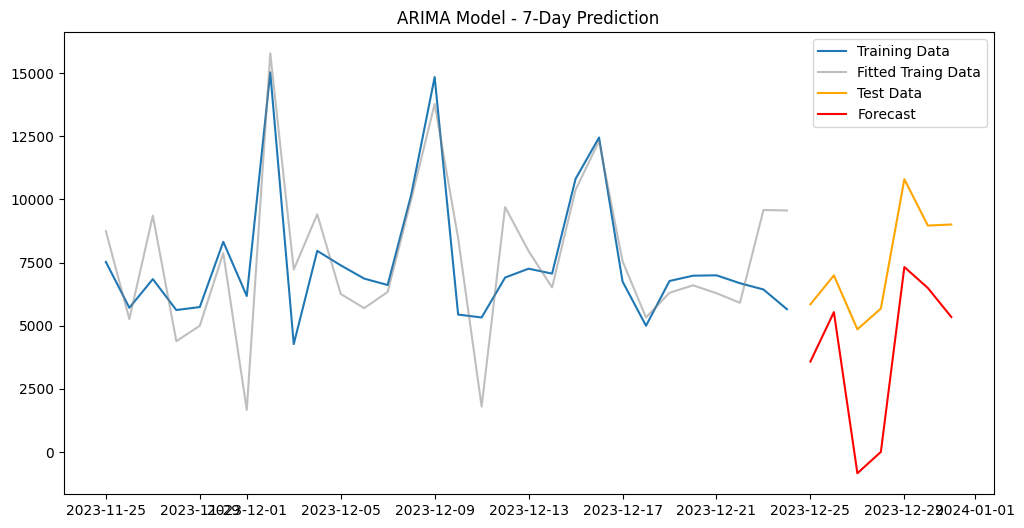

In [267]:
#Plot past month data
plt.figure(figsize=(12, 6))
plt.plot(train_y[-30:], label='Training Data')
plt.plot(fitted_model.fittedvalues[-30:], label='Fitted Traing Data', color='gray', alpha=.5)
plt.plot(test_y, label='Test Data', color='orange')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model - 7-Day Prediction')
plt.show()

## Monthly

In [ ]:
monthly_rides = df.resample('M').sum()


In [ ]:
monthly_rides['ride_id'].plot()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_rides['ride_id'].diff().dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_rides['ride_id'].diff().dropna(), lags=10, ax=ax2)
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly_rides['ride_id'], model='additive', period=1)

# Plot the decomposition
decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_rides['ride_id'])
print(f'p-value: {result[1]}')

In [ ]:
model = sm.tsa.ARIMA(monthly_rides['ride_id'], order=(4, 12, 1))
fitted_model = model.fit()

# Print AIC and BIC
print(f'AIC: {fitted_model.aic}')
print(f'BIC: {fitted_model.bic}')
fitted_model.summary()

In [ ]:
model = sm.tsa.ARIMA(df['ride_id'], order=(4, 1, 1))
fitted_model = model.fit()

fitted_model.summary()

In [ ]:
monthly_rides['ride_id'].diff(4).plot()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df['rides'] is the time series with quarterly data
model = SARIMAX(monthly_rides['ride_id'], 
                order=(4, 0, 1),  # non-seasonal ARIMA orders
                seasonal_order=(0, 0, 0, 4))  # quarterly seasonality
model_fit = model.fit()

# Make predictions for the next month
forecast = model_fit.forecast(steps=1)  # Predict the next month's value
forecast

In [ ]:
monthly_rides.plot()

## Zipcode

In [ ]:
df = pd.read_csv("/Users/westonshuken/Documents/_2025/CitiBike/monthly_rides_by_station_2022_2023.csv")
df.head()

In [ ]:
zips = pd.read_csv("/Users/westonshuken/Documents/_2025/CitiBike/stationzipdata.csv")
zips.head()

In [ ]:
df = pd.merge(df, zips, on='end_station_name', how='left')
df.head()

In [ ]:
columns = {'end_station_name':'Station_Name','ended_at':'Date','ride_id':'rides','ZIP Code':'zipcode'}
df = df.rename(columns=columns)
df = df.drop(columns=['end_lng_x', 'end_lat_x','end_lng_y', 'end_lat_y'])

In [ ]:
df = df[df['zipcode'] == '11207']

In [ ]:
df = df.drop(columns=['Station_Name','zipcode'])

In [ ]:
df = df.groupby('Date').sum('rides').reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df_month = df.resample('M').sum()
df_month.plot()

In [ ]:
df['rides'].plot()